In [1]:
using ITensors
using ITensorTDVP
using Plots
using Observers
using LinearAlgebra
using Statistics
using ProgressBars   
using DSP
using Symbolics
using Trapz
using NBInclude
@nbinclude("Graphing_code.ipynb")
@nbinclude("Enrichment_functions.ipynb")
@nbinclude("New_mapping_functions_06_01_2023.ipynb")


"""
The reaction coordinate essentially shuts off the bath modes for a symmetric spectral density.

The hopping terms are ony defined via their square, which root should be used? Currently taking positive root.

I'm going to assume both have the same spectral function. I'm also going to write the function so there's only one mode
coupled to each bath. This should be easily changed.


MAKE SURE THE HAMILTONIAN HAS THE CORRECT MINUSES FROM THE NOTES.
MAKE SURE THE ORDER OF THE COUPLING TERMS IN THE HAMILTONIAN ARE CORRECT
(i.e. whether you have to switch Cdag and C)
"""

"The reaction coordinate essentially shuts off the bath modes for a symmetric spectral density.\n\nThe hopping terms are ony defined via their square, which root should be used? Currently taking positive root.\n\nI'm going to assume both have the same spectral function. I'm a" ⋯ 98 bytes ⋯ "ly changed.\n\nI'm also going to choose the order of the bath and bath ancilla modes such that \nthe first and last modes are ancillas, i.e the order is opposite for the left bath\nthan for the right bath. \n\n\nMAKE SURE THE HAMILTONIAN HAS THE CORRECT MINUSES FROM THE NOTES.\n"

In [11]:
Nbl = 4                                     #Number of left bath sites
Nbr = 4                                      #Number of right bath sites
Ns = 2                                       #Number of system sites (not including ancilla)                                               
Krylov_cutoff = 1E-5                         # site list
βr = 0;                                       #inverse temperature of right bath
βl = 0;                                       #inverse temperature of left bath
k1 = 3
k2 = 5                                       # Number of Krylov states
τ_Krylov = 1
V = 1

tdvp_cutoff = 1e-30                         
δt1 = 5e-2                                  # Time-step
δt2 = 1e-1
δt = 5e-2
T = 10                                     # Total time
T_enrich = 1                         # Time when the state is enriched in each step

1

In [14]:
print("Model choice: bath eigenmodes = 1, thermofield eigenmodes = 2, Tridiagonalisation = 3")
choice = parse(Int,readline())


print("Spectral function choice: Box = 1, Semi_circle = 2")
spec_fun = parse(Int,readline())


print("Discretization choice: Direct = 1, Reaction = 2")
disc_choice = parse(Int,readline())

#---------------------------------------------------------------------------------------------------------------------------

#This block defines all of the simple dependent variables that will be used for various functions
@time begin

N = 2*Nbl + 2*Nbr +2*Ns                       #Number total sites
s = siteinds("Fermion", N)                    # Array of site indices  
sites = 1:N                                   # site list
ϵi = 0.5*ones(Ns);                            #self energies of system modes
left_bath_bool = Nbl>0
right_bath_bool = Nbr>0
gate_list = []
terms = OpSum()                               #Create Hamiltonian MPO 
H_single = zeros(N,N)                         #Create single particle matrix hamiltonian

c = ops(s, [("C", n) for n in sites]);        # annihilation operators
cd = ops(s, [("Cdag", n) for n in sites]);    # creation operators
Imat = [1.0 0.0; 0.0 1.0]                     # identity matrix
Id = Vector{ITensor}(undef,N)
for i=1:N
   Id[i] = ITensor(Imat,s[i]',s[i])           # identiy operators
end;


T_unenriched = round(T-T_enrich,digits=10)       # Time when the state is no longer enriched each step                                             # Number of time steps
nframe_en = Int(ceil(T_enrich/δt))
times1 = Vector(LinRange(δt1,T_enrich, Int(ceil(T_enrich/δt1))))
times2 = Vector(LinRange(T_enrich+δt2,T, Int(ceil(T_unenriched/δt2))))
 

if spec_fun == 1
    Jl = J_box
    Jr = J_box
elseif spec_fun == 2
    Jl = J_ell
    Jr = J_ell
end
    
end
println("Simple variables done")
#-----------------------------------------------------------------------------------------------------------------------

#This block initialises the full hamiltonian and the initial state.
@time begin

    #Left bath initialisation
    if left_bath_bool
        side="left"
        Vk_L,ϵb_L,fk_L,left_gates = initialise_bath(N,Jl,Nbl,βl,ϵi,side,disc_choice,choice)
        gate_list = [left_gates]
        H_L_terms,H_single = H_bath(Nbl,Vk_L,ϵb_L,fk_L,side,H_single,choice,s)
        terms += H_L_terms
    end

end
println("left initialised")

@time begin

    #System initialisation
    system_gates = initialise_system_gates(Nbl,Ns)
    push!(gate_list,system_gates)
    H_S_terms, H_single = H_S(ϵi,Ns,Nbl,H_single)
    terms += H_S_terms

end
println("system initialised")

@time begin

    #Right bath initialisation
    if right_bath_bool
        side="right"
        Vk_R,ϵb_R,fk_R,right_gates = initialise_bath(N,Jr,Nbr,βr,ϵi,side,disc_choice,choice)
        push!(gate_list,right_gates)
        H_R_terms,H_single = H_bath(Nbr,Vk_R,ϵb_R,fk_R,side,H_single,choice,s)
        terms += H_R_terms
    end
    
end
println("right initialised")

@time begin

    #State
    ψ = initialise_psi(gate_list,s)

end
println("state created")

@time begin

    #Hamiltonian MPO
    H = MPO(terms,s)
    
end
println("H created")
#--------------------------------------------------------------
@time begin

    Krylov = Krylov_states(H,ψ,k1,τ_Krylov,s);

end
println("Krylov created")
@time begin

    ψ[N]= ψ[N]/norm(ψ)
    ψ1 = enrich_generic3(ψ, Krylov; Krylov_cutoff);

end
println("state enriched")
println("1 - overlap of initial state and enriched initial state = ",1-inner(ψ,ψ1))
ψ = ψ1
Ci = transpose(correlation_matrix(ψ,"Cdag","C"));

###Initial Entropy
SvN_init = entanglement_entropy(ψ);

###density of initial state
num_init = expect(ψ,"n");

###Initial state
ψ_init = deepcopy(ψ);

Model choice: bath eigenmodes = 1, thermofield eigenmodes = 2, Tridiagonalisation = 3stdin> 2
Spectral function choice: Box = 1, Semi_circle = 2stdin> 2
Discretization choice: Direct = 1, Reaction = 2stdin> 2
  0.042767 seconds (83.34 k allocations: 4.452 MiB, 96.73% compilation time)
Simple variables done
  1.039717 seconds (2.57 M allocations: 132.066 MiB, 4.33% gc time, 98.31% compilation time)
left initialised
  0.000137 seconds (212 allocations: 118.719 KiB)
system initialised
  0.000641 seconds (1.23 k allocations: 505.656 KiB)
right initialised
  0.003259 seconds (20.30 k allocations: 5.828 MiB)
state created
  0.004018 seconds (33.20 k allocations: 7.478 MiB)
H created
  0.024133 seconds (98.67 k allocations: 28.601 MiB)
Krylov created
  0.010489 seconds (53.31 k allocations: 15.479 MiB)
state enriched
1 - overlap of initial state and enriched initial state = -2.220446049250313e-16 - 2.3111159332646837e-33im


true

In [16]:
@show(tdvp_cutoff)
ψe = deepcopy(ψ)
obs = Observer("times" => current_time,"corr" => measure_correlation_matrix,"SvN" =>measure_SvN)

for i in ProgressBar(1:(nframe_en))
    
    ψe = tdvp(H,-im * δt,ψe; time_step = -im * δt1, cutoff = tdvp_cutoff, 
        outputlevel=1, normalize=false, (observer!)=obs)
  
    Krylov_i = Krylov_states(H,ψe,k2,τ_Krylov,s);
  #  @assert(minimum(Krylov_linkdims(Krylov) .- length(Krylov)) ==0)
    ψe2 = enrich_generic3(ψe, Krylov_i; Krylov_cutoff)
    @assert abs(1-inner(ψe2,ψe)) <1e-10
    ψe = ψe2
    
end

@time ψf = tdvp(H,-im * T_unenriched,ψe; time_step = -im * δt2, cutoff = tdvp_cutoff,
   outputlevel=1, normalize=false, (observer!)=obs)


res = results(obs)
times = res["times"]
corr = res["corr"]
SvN = res["SvN"];  



tdvp_cutoff = 1.0e-30


0.0%┣                                               ┫ 0/20 [00:00<00:-1, -0s/it]

After sweep 1: maxlinkdim=17

 maxerr=9.42E-31 current_time=0.0 - 0.05im time=9.584


5.0%┣██▏                                        ┫ 1/20 [01:24<Inf:Inf, InfGs/it]


After sweep 1: maxlinkdim=37 maxerr=7.08E-31 current_time=0.0 - 0.05im time=0.39


LoadError: InterruptException:

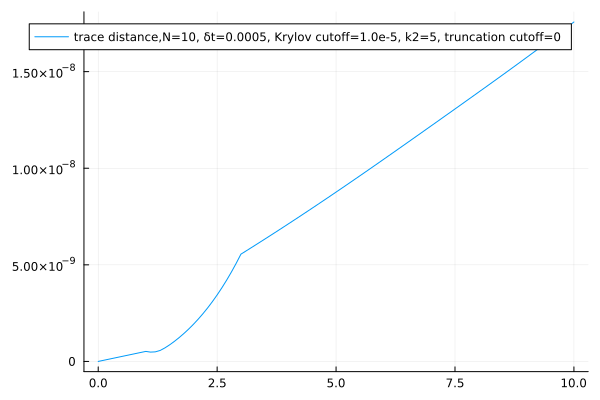

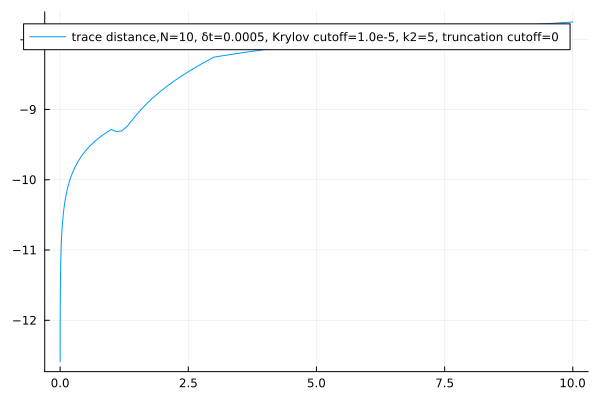

In [35]:
other_norms=false
save_bool = false
error_propagation2(corr,times1,times2,H_single,δt1,δt2,Ci,N,Krylov_cutoff,k2,tdvp_cutoff,other_norms,save_bool)


┌ Info: Saved animation to C:\Users\david\Purified-evolution-various-julia-scripts-Latest\entanglement_entropy_anim,T=10,model=3.gif
└ @ Plots C:\Users\david\.julia\packages\Plots\zzg7i\src\animation.jl:149


Plots.AnimatedGif("C:\\Users\\david\\Purified-evolution-various-julia-scripts-Latest\\entanglement_entropy_anim,T=10,model=3.gif")
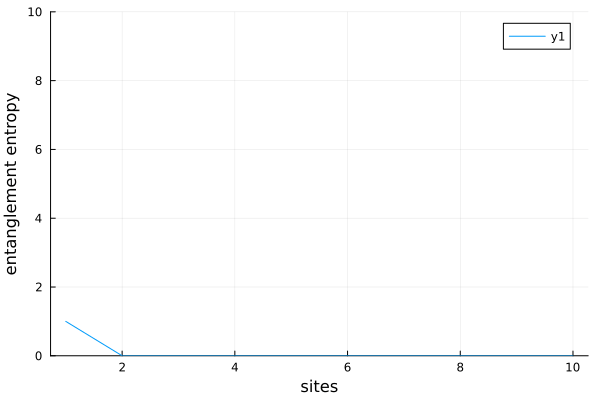

In [48]:
nframe = length(times1) +length(times2)
site_lim = N
SvN_ylim = 10
entanglement_animation(SvN, nframe, site_lim, SvN_ylim,T,model)

In [38]:
U_step2 = exp(-im*δt2*H_single)
C = corr[100]
Cf = U_step2*C*U_step2'

12×12 Matrix{ComplexF64}:
          0.5+0.0im          …    1.4505e-59+1.95576e-59im
     0.499244-0.0274861im       -1.55477e-59-1.87305e-59im
  1.15588e-20-2.78695e-20im     -9.53342e-57-2.584e-57im
  9.78431e-21-2.80727e-20im      9.76453e-57+1.97735e-57im
 -2.48444e-21-1.94494e-21im      9.96622e-41-3.85503e-39im
 -2.57403e-21-1.79248e-21im  …  -1.12377e-40-3.85309e-39im
  1.59172e-22-1.63653e-22im      1.91933e-41-5.70831e-42im
  1.55064e-22-2.09816e-22im      3.19706e-40-5.27988e-43im
 -4.02578e-41-3.98485e-41im     -1.38819e-60-1.24859e-60im
  -5.2328e-41-3.87744e-41im     -3.37241e-62-7.97983e-59im
   1.4913e-59-1.49724e-59im  …   2.95371e-87-5.1452e-79im
   1.4505e-59-1.95576e-59im      2.98328e-77+6.74161e-95im

In [43]:
opnorm(corr[101] - Cf)

6.888400985196601e-11

1×10 Matrix{Float64}:
 3.07725e-16  1.66582e-18  -6.44109e-17  …  1.04843e-16  -1.71387e-16

In [2]:

"""

What to do next:

-We need to work out whether the relative magnitudes of the Krylov states matter, i.e. do we include the delta t?

-The norm of ρ_n is falling, I think these two errors are connected as they both breakdown at the same time.
-I think I should have error checks for various properties of all the objects, i.e. the norm of ρ_n etc.

-Once the projector is diagonalised, the spectra are either 0 or 1, but numerically they deviate from this by an order of
~1e-14. Is there a way of recovering Vp from the diagonal matrix after the values have been rounded?

-The stochastic enrichment method is much more efficient and seems quite straight forward to implement.

-In the paper, they only use k=3 (two Krylov states) to avoid the high bond dimensions of higher order Krylov states.

-Ask on the discourse page if 1TDVP is implemented as this could be another option.



"""
     

"\nWhat to do next:\n\n-We need to work out whether the relative magnitudes of the Krylov states matter, i.e. do we include the delta t?\n\n-The norm of ρ_n is falling, I think these two errors are connected as they both breakdown at the same time.\n-I think I should have error" ⋯ 344 bytes ⋯ " more efficient and seems quite straight forward to implement.\n\n-In the paper, they only use k=3 (two Krylov states) to avoid the high bond dimensions of higher order Krylov states.\n\n-Ask on the discourse page if 1TDVP is implemented as this could be another option.\n\n\n\n"

In [ ]:
"""
Potential efficiency improvements:

-Always sweeping towards the centre will prevent Projectors having an unnecessarily large dimension.

-At the end of the enrichment, the enriched state is almost canonical apart from the first sight which carries this 
extra k factor. Does TDVP need an orthogonal centre at N? If not, we may be able to avoid orthogonalization?

-    In most cases, abs_maxdim will be very high. We don't want to use this. However, if 
    for the other option we use the sum of all the linkdimensions (for n-1) of the Krylov states, 
    It won't be in canonical form so many of the dimensions will actually correspond to the same dimension. 
    Again, this isn't a huge problem because it will still likely be much less than abs_maxdim. I'm not sure how 
    this can be prevented, so I will just use the sum.
    
- Question: Does the kth Krylov state always contain within it the dimensions of the lower order Krylov states?
 This would solve the problem stated just about and would be more efficient.


-For 1TDVP, they found that for k=5 the creation of the Krylov states and the enrichment step were subleading to the TDVP step, but this isn't
what I have at the moment. 2TDVP is slower than 1TDVP but more accurate, so we don't know if these steps should be subleading to TDVP or not, but 
there's definitely ways of increasing the efficiency of these steps.


-There's a more efficient but less accurate way to apply H to ψ, by using the variational approach that's used in TDVP itself. 


-In the paper, they say to use τ=δt but I'm not sure about this as for small delta t, these states won't be that different (think about this more).


-The bottleneck is creating the Krylov states, see if you can make the function more efficient (Vectorise?). 

-During the enrichment, there will be sites that are aleady max rank, i.e close to the first site. Instead of SvDing through
these sights manually, we could use orthogonalize to go between sites that can be enriched. I.e. say we have just enriched
site k, and the next site that can be enriched is site k-n. Instead of SvDing the n states between these two, we could use 
orthogonalize(ψ,k-n) to move to this sight.
"""